# Diffusion Maps + LAWGD Generative Modelling on MNIST

This notebook implements an autoencoder + diffusion-maps latent analysis, then mirrors the LAWGD scheme from Tests 1 & 2 to sample new MNIST digits directly in latent space.

**Pipeline:**

1. Load MNIST and normalize images.
2. Train an autoencoder (either MLP-based or CNN-based) to learn a low-dimensional latent space.
3. Map training images to latent codes.
4. Apply Diffusion Maps on latent codes to obtain diffusion coordinates for diagnostics.
5. Build the LAWGD kernel operators on the latent samples (same normalization as Tests 1 & 2).
6. Run LAWGD particle transport to draw new latent vectors.
7. Decode LAWGD latent vectors back to images and visually inspect generated digits.


In [1]:
# Configure core libraries, plotting defaults, and compute device
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances
from scipy.sparse.linalg import eigs
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from grad_ker1 import grad_ker1
from K_tar_eval import K_tar_eval

try:
    import cupy as cp
    from grad_ker1_gpu import grad_ker1 as grad_ker1_gpu
    from K_tar_eval_gpu import K_tar_eval as K_tar_eval_gpu
    GPU_AVAILABLE = True
except Exception:
    cp = None
    grad_ker1_gpu = None
    K_tar_eval_gpu = None
    GPU_AVAILABLE = False

np.random.seed(42)
torch.manual_seed(42)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_gpu_lawgd = bool(GPU_AVAILABLE and torch.cuda.is_available())
print("Using device:", device)
print(f"LAWGD GPU backend: {'enabled' if use_gpu_lawgd else 'disabled'}")

Using device: cuda
LAWGD GPU backend: enabled


In [2]:
# Load MNIST datasets and build training/test data loaders
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 1]
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(train_dataset), "Test size:", len(test_dataset))


Train size: 60000 Test size: 10000


In [3]:
# Define the fully connected autoencoder blocks used for the MLP baseline
latent_dim = 8  # dimension of the latent space

class MLPEncoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )

    def forward(self, x):
        return self.net(x)


class MLPDecoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, z):
        x_flat = self.net(z)
        return x_flat.view(-1, 1, 28, 28)


class MLPAutoencoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.encoder = MLPEncoder(latent_dim)
        self.decoder = MLPDecoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


In [4]:
# Define the convolutional autoencoder architecture for improved spatial modeling
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 1x28x28 -> 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 16x14x14 -> 32x7x7
            nn.ReLU(),
        )
        self.fc = nn.Linear(32 * 7 * 7, latent_dim)

    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        z = self.fc(h)
        return z


class CNNDecoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(
                32, 16, kernel_size=3, stride=2, padding=1, output_padding=1
            ),  # 32x7x7 -> 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(
                16, 1, kernel_size=3, stride=2, padding=1, output_padding=1
            ),  # 16x14x14 -> 1x28x28
            nn.Sigmoid(),
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(-1, 32, 7, 7)
        x = self.deconv(h)
        return x


class CNNAutoencoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


In [5]:
# Choose which autoencoder variant to train and move it to the target device
# Option 1: MLP autoencoder
# autoencoder = MLPAutoencoder(latent_dim=latent_dim).to(device)

# Option 2: CNN autoencoder (default here)
autoencoder = CNNAutoencoder(latent_dim=latent_dim).to(device)

print(autoencoder)


CNNAutoencoder(
  (encoder): CNNEncoder(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
    )
    (fc): Linear(in_features=1568, out_features=8, bias=True)
  )
  (decoder): CNNDecoder(
    (fc): Linear(in_features=8, out_features=1568, bias=True)
    (deconv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (3): Sigmoid()
    )
  )
)


In [6]:
# Train the selected autoencoder on MNIST with Adam and report epoch losses
num_epochs = 10
learning_rate = 1e-3

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

autoencoder.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        recon, z = autoencoder(images)
        loss = criterion(recon, images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.0564
Epoch [2/10], Loss: 0.0309
Epoch [2/10], Loss: 0.0309
Epoch [3/10], Loss: 0.0269
Epoch [3/10], Loss: 0.0269
Epoch [4/10], Loss: 0.0251
Epoch [4/10], Loss: 0.0251
Epoch [5/10], Loss: 0.0240
Epoch [5/10], Loss: 0.0240
Epoch [6/10], Loss: 0.0233
Epoch [6/10], Loss: 0.0233
Epoch [7/10], Loss: 0.0228
Epoch [7/10], Loss: 0.0228
Epoch [8/10], Loss: 0.0223
Epoch [8/10], Loss: 0.0223
Epoch [9/10], Loss: 0.0220
Epoch [9/10], Loss: 0.0220
Epoch [10/10], Loss: 0.0217
Epoch [10/10], Loss: 0.0217


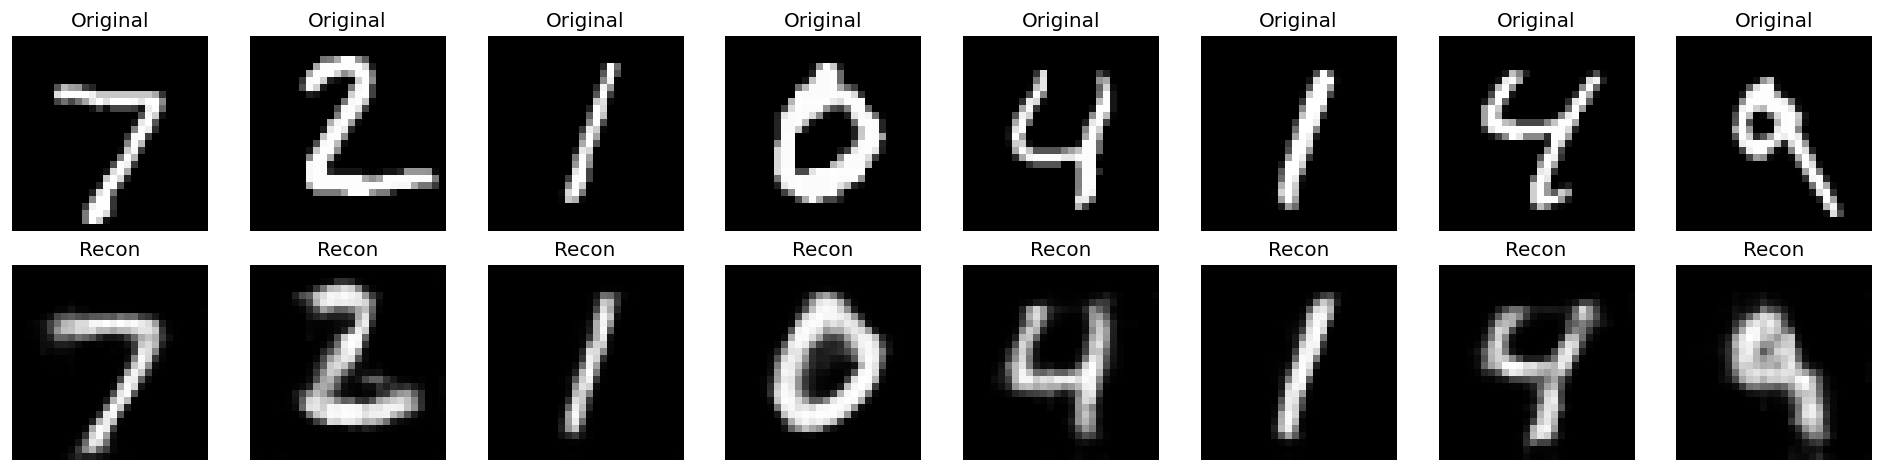

In [7]:
# Visualize a batch of original vs reconstructed digits to sanity-check training
autoencoder.eval()
images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    recon, _ = autoencoder(images)

images_cpu = images.cpu().numpy()
recon_cpu = recon.cpu().numpy()

n_show = 8
fig, axes = plt.subplots(2, n_show, figsize=(2 * n_show, 4))
for i in range(n_show):
    axes[0, i].imshow(images_cpu[i, 0], cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")
    axes[1, i].imshow(recon_cpu[i, 0], cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Recon")
plt.tight_layout()
plt.show()


In [8]:
# Encode the full training set to collect latent vectors and labels for DM
autoencoder.eval()

all_latents = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        _, z = autoencoder(images)
        all_latents.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

Z = np.concatenate(all_latents, axis=0)   # shape (N, latent_dim)
y_labels = np.concatenate(all_labels, axis=0)

print("Latent codes shape:", Z.shape)


Latent codes shape: (60000, 8)


In [9]:
# Prepare the latent sample subset and kernel matrix required for diffusion maps
# Subsample for Diffusion Maps (e.g., 5000 points)
max_dm_samples = 5000
N_total = Z.shape[0]

if N_total > max_dm_samples:
    idx_dm = np.random.choice(N_total, max_dm_samples, replace=False)
else:
    idx_dm = np.arange(N_total)

Z_dm = Z[idx_dm]
labels_dm = y_labels[idx_dm]

print("Latent points used for DM:", Z_dm.shape)

# Pairwise distances
dists = pairwise_distances(Z_dm, metric="euclidean")

# Epsilon via median heuristic
med_sq = np.median(dists**2)
eps = med_sq / (2.0 * np.log(Z_dm.shape[0]))
print("Chosen epsilon:", eps)

# Gaussian kernel
K = np.exp(-dists**2 / (2.0 * eps))

# Row-normalize -> Markov matrix P
row_sums = K.sum(axis=1, keepdims=True)
P = K / row_sums


Latent points used for DM: (5000, 8)
Chosen epsilon: 73.66424402449464
Chosen epsilon: 73.66424402449464


In [10]:
# Compute the leading diffusion-map eigenpairs to obtain coordinates and spectra
m = 15  # number of eigenvectors

vals, vecs = eigs(P.T, k=m, which="LR")

idx_sort = np.argsort(-np.abs(vals))
vals = vals[idx_sort]
vecs = vecs[:, idx_sort]

lam = np.real(vals)
phi = np.real(vecs)

print("Leading eigenvalues:", lam)


Leading eigenvalues: [1.         0.91510283 0.8545348  0.84450574 0.83023434 0.74324369
 0.7358334  0.68667248 0.65206863 0.62753852 0.61127156 0.562176
 0.5419142  0.52380128 0.50020424]


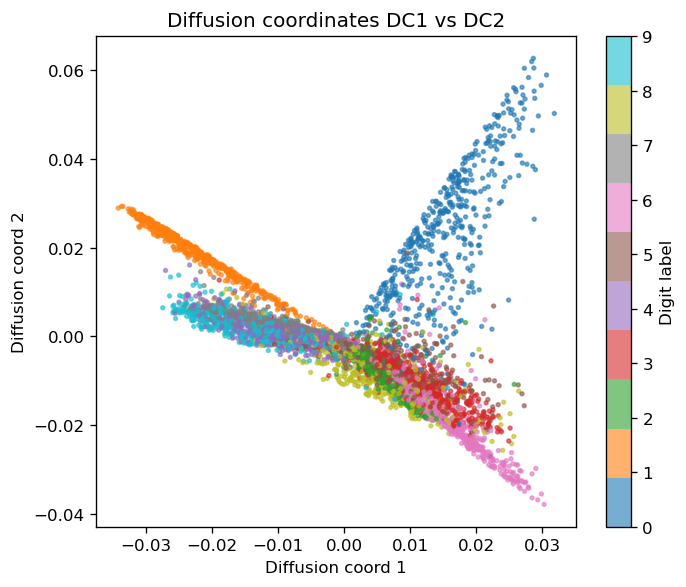

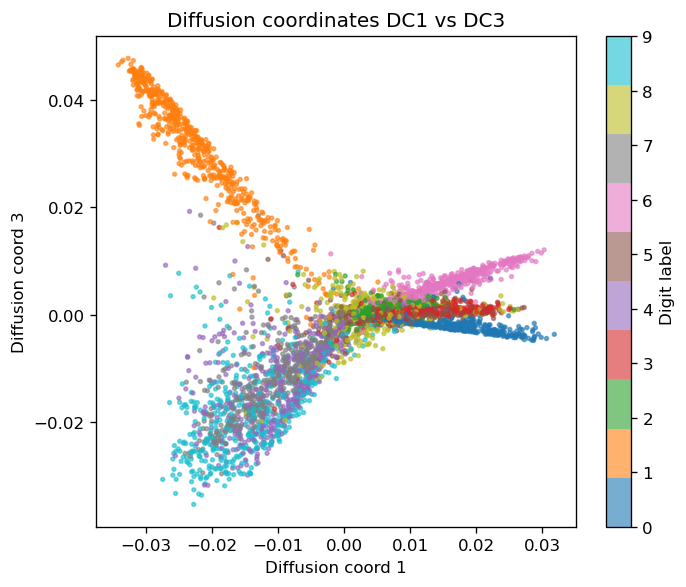

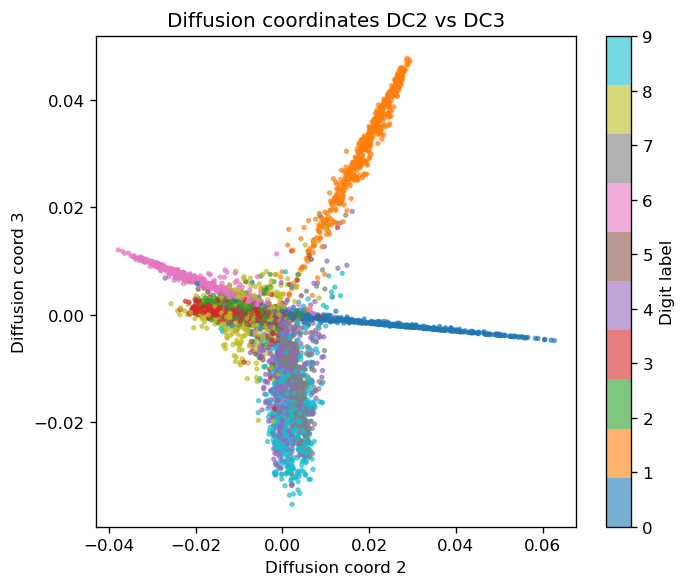

In [11]:
# Plot several diffusion-coordinate pairs to inspect class separation visually
pairs = [(1, 2), (1, 3), (2, 3)]
for i, j in pairs:
    dc_i = phi[:, i]
    dc_j = phi[:, j]

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(dc_i, dc_j, c=labels_dm, s=5, alpha=0.6, cmap="tab10")
    plt.xlabel(f"Diffusion coord {i}")
    plt.ylabel(f"Diffusion coord {j}")
    plt.title(f"Diffusion coordinates DC{i} vs DC{j}")
    plt.colorbar(scatter, label="Digit label")
    plt.tight_layout()
    plt.show()


In [12]:
# Compute diffusion-space mean and covariance for Gaussian diagnostics
num_dc = 8  # number of nontrivial diffusion coords to use (<= m-1)
Y_dm = phi[:, 1:1 + num_dc]
print("Diffusion-space data shape:", Y_dm.shape)

mu_Y = np.mean(Y_dm, axis=0)
cov_Y = np.cov(Y_dm.T)

print("Mean in diffusion space:", mu_Y)
print("Covariance shape:", cov_Y.shape)

Diffusion-space data shape: (5000, 8)
Mean in diffusion space: [ 5.66213743e-17 -4.54525306e-17 -8.19899704e-18 -2.01727524e-17
 -6.30606678e-18 -4.45199433e-18  7.99360578e-19 -1.11022302e-18]
Covariance shape: (8, 8)


## LAWGD-based latent generation
Following the LAWGD workflow from Tests 1 & 2, we now treat the autoencoder latents as the target samples and run Wasserstein gradient dynamics directly in latent space. Diffusion maps remain available above for visualization, but the sampling path below no longer uses the Gaussian model.

In [13]:
# Standardize DM latents and build the LAWGD kernel operators
Z_dm_mean = np.mean(Z_dm, axis=0, keepdims=True)
Z_dm_std = np.std(Z_dm, axis=0, keepdims=True) + 1e-8
Z_dm_centered = (Z_dm - Z_dm_mean) / Z_dm_std
X_tar = Z_dm_centered.astype(np.float64)  # target samples for LAWGD
sq_tar = np.sum(X_tar ** 2, axis=1)

lawgd_dists = pairwise_distances(X_tar, metric="euclidean")
eps_lawgd = np.median(lawgd_dists**2) / (2.0 * np.log(X_tar.shape[0] + 1))
eps_lawgd = float(max(eps_lawgd, 1e-6))
data_kernel = np.exp(-lawgd_dists**2 / (2.0 * eps_lawgd))

p_x = np.sqrt(np.sum(data_kernel, axis=1))
data_kernel_norm = data_kernel / (p_x[:, None] * p_x[None, :] + 1e-12)
D_y = np.sum(data_kernel_norm, axis=0)
rw_kernel = 0.5 * (data_kernel_norm / (D_y + 1e-12) + data_kernel_norm / (D_y[:, None] + 1e-12))
rw_kernel = np.nan_to_num(rw_kernel)

print("LAWGD target shape:", X_tar.shape)
print("LAWGD epsilon:", eps_lawgd)

LAWGD target shape: (5000, 8)
LAWGD epsilon: 0.8647678246281246


In [14]:
# Build spectral quantities and LAWGD weights
lambda_ns, phi = np.linalg.eigh(rw_kernel)
phi = np.real(phi[:, ::-1])
lambda_ns = np.real(lambda_ns[::-1])

tol = 1e-6
reg = 1e-3
lambda_ = -lambda_ns + 1.0
inv_lambda = np.zeros_like(lambda_)
inv_lambda[1:] = 1.0 / np.clip(lambda_[1:], 1e-12, None)
inv_lambda *= eps_lawgd

lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = eps_lawgd / (lambda_ns[mask] + reg)
above_tol = int(np.sum(mask))
phi_trunc = phi[:, :above_tol]
lambda_ns_s_ns = (lambda_ns_inv * inv_lambda * lambda_ns_inv)[:above_tol]

p_tar = np.sum(data_kernel, axis=0)
sqrt_p = np.sqrt(p_tar + 1e-12)
D_vec = np.sum(data_kernel / sqrt_p[:, None] / sqrt_p[None, :], axis=1)

print("Retained eigenvectors for LAWGD:", above_tol)

Retained eigenvectors for LAWGD: 4946


In [15]:
# Run LAWGD particle transport directly in latent space
m_particles = 256
num_iters = 400
step_size = 2.0
latent_dim = X_tar.shape[1]
rng = np.random.default_rng(0)

grad_fn = grad_ker1_gpu if use_gpu_lawgd else grad_ker1
K_eval_fn = K_tar_eval_gpu if use_gpu_lawgd else K_tar_eval
xp = cp if use_gpu_lawgd else np

init_particles = rng.normal(0.0, 1.0, size=(m_particles, latent_dim))
if use_gpu_lawgd:
    X_tar_dev = cp.asarray(X_tar)
    p_tar_dev = cp.asarray(p_tar)
    sq_tar_dev = cp.asarray(sq_tar)
    D_vec_dev = cp.asarray(D_vec)
    phi_trunc_dev = cp.asarray(phi_trunc)
    lambda_ns_s_ns_dev = cp.asarray(lambda_ns_s_ns)
    x_hist = cp.zeros((m_particles, latent_dim, num_iters), dtype=cp.float64)
    x_hist[:, :, 0] = cp.asarray(init_particles, dtype=cp.float64)
else:
    X_tar_dev = X_tar
    p_tar_dev = p_tar
    sq_tar_dev = sq_tar
    D_vec_dev = D_vec
    phi_trunc_dev = phi_trunc
    lambda_ns_s_ns_dev = lambda_ns_s_ns
    x_hist = np.zeros((m_particles, latent_dim, num_iters), dtype=np.float64)
    x_hist[:, :, 0] = init_particles

lawgd_loop = trange(num_iters - 1, desc="LAWGD iterations", unit="step")
for t in lawgd_loop:
    grad_matrix = grad_fn(x_hist[:, :, t], X_tar_dev, p_tar_dev, sq_tar_dev, D_vec_dev, eps_lawgd)
    cross_matrix = K_eval_fn(X_tar_dev, x_hist[:, :, t], p_tar_dev, sq_tar_dev, D_vec_dev, eps_lawgd)
    tmp = phi_trunc_dev.T @ cross_matrix
    tmp = lambda_ns_s_ns_dev[:, None] * tmp
    lawgd_push = phi_trunc_dev @ tmp
    for dim in range(latent_dim):
        sum_term = grad_matrix[:, :, dim] @ lawgd_push
        x_hist[:, dim, t + 1] = x_hist[:, dim, t] - (step_size / m_particles) * xp.sum(sum_term, axis=1)
    if (t + 1) % 25 == 0 or (t + 1) == num_iters - 1:
        step_norm = x_hist[:, :, t + 1] - x_hist[:, :, t]
        if use_gpu_lawgd:
            mean_disp = float(cp.mean(cp.linalg.norm(step_norm, axis=1)).get())
        else:
            mean_disp = float(np.mean(np.linalg.norm(step_norm, axis=1)))
        lawgd_loop.set_postfix({"mean_step": f"{mean_disp:.3e}"})

if use_gpu_lawgd:
    Z_new_std = cp.asnumpy(x_hist[:, :, -1])
else:
    Z_new_std = x_hist[:, :, -1]

Z_new_lawgd = Z_new_std * Z_dm_std + Z_dm_mean
print("LAWGD latent samples shape:", Z_new_lawgd.shape)

LAWGD iterations:   0%|          | 0/399 [00:00<?, ?step/s]

LAWGD latent samples shape: (256, 8)


In [16]:
# Decode LAWGD-generated latent vectors
autoencoder.eval()
Z_new_tensor = torch.from_numpy(Z_new_lawgd).float().to(device)

with torch.no_grad():
    lawgd_images = autoencoder.decoder(Z_new_tensor)

lawgd_images_cpu = lawgd_images.cpu().numpy()
print("Decoded LAWGD images shape:", lawgd_images_cpu.shape)

Decoded LAWGD images shape: (256, 1, 28, 28)


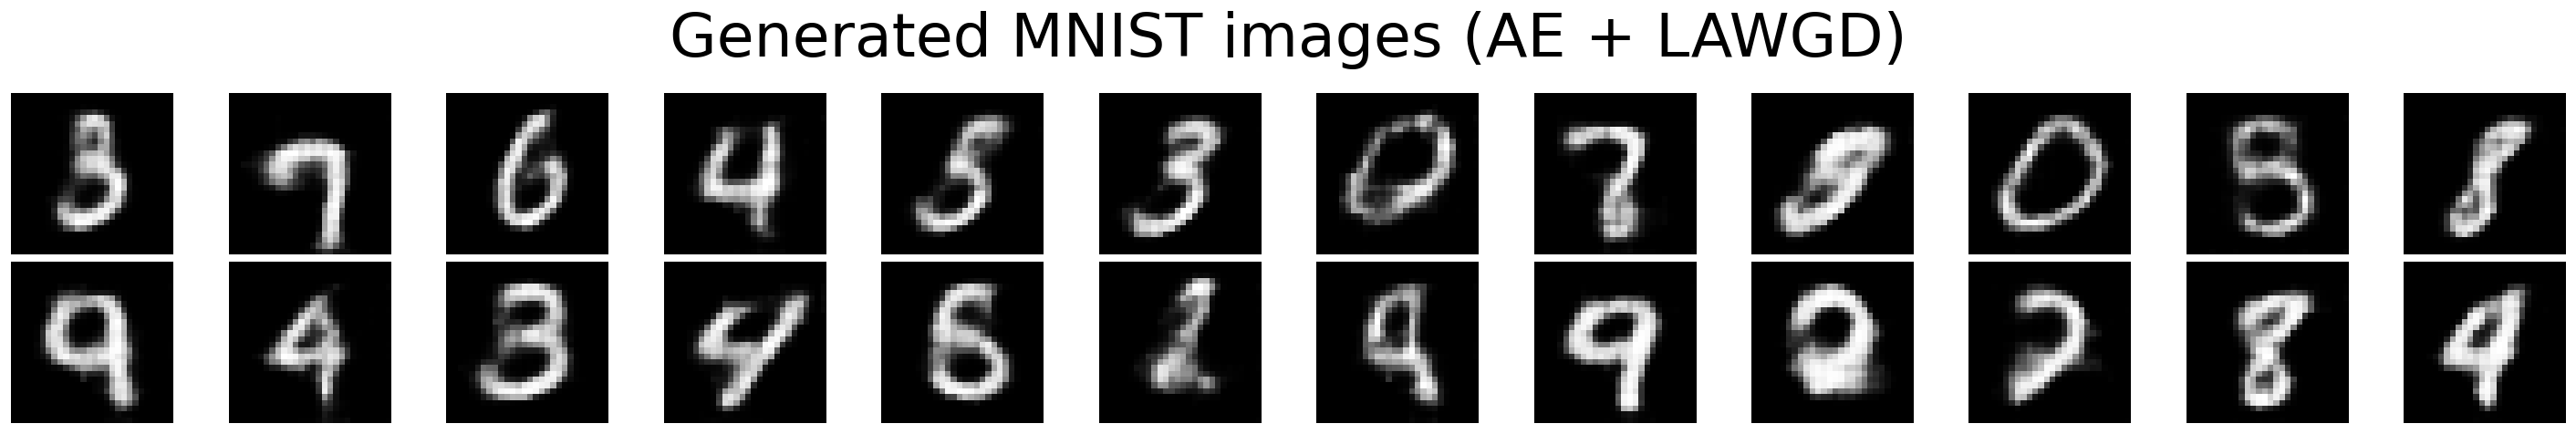

In [26]:
# Visualize digits generated via LAWGD transport
n_show = 24
fig, axes = plt.subplots(2, n_show // 2, figsize=(2 * (n_show // 2), 4))

for i in range(n_show):
    ax = axes[i // (n_show // 2), i % (n_show // 2)]
    ax.imshow(lawgd_images_cpu[i, 0], cmap="gray")
    ax.axis("off")

plt.suptitle("Generated MNIST images (AE + LAWGD)", fontsize=40)
plt.tight_layout()
plt.show()